In order to create the data to use in our GCN based deep learning model, run the cell below.

In [10]:
#
"""
Created on Wed Oct 30 13:37:08 2019

@author: umaer
"""

import torch
import torch_geometric
from torch_geometric.io import parse_txt_array
from torch_geometric.io.off import face_to_tri
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_undirected
from torch_geometric.data import InMemoryDataset
from torch_geometric.transforms.random_flip import RandomFlip
from torch_geometric.transforms.random_rotate import RandomRotate
from sklearn.model_selection import train_test_split
import os
import glob
import random


class Dataset(InMemoryDataset):
    
    def __init__(self, path, train=True, transform=None, pre_transform=None, 
                 pre_filter=None):
        
        self.path = path
        self.train = train
        self.transform=transform
        pt_path = 'tmp/processed/training.pt'
        self.data, self.slices = torch.load(pt_path)

    def read_off(self, file):
        # Some files may contain a bug and do not have a carriage return after OFF.
        with open(file, 'r') as f:
            src = f.read().split('\n')[:-1]
            
            if src[0] == 'OFF':
                src = src[1:]
            else:
                src[0] = src[0][3:]
        
            num_nodes, num_faces = [int(item) for item in src[0].split()[:2]]
        
            pos = parse_txt_array(src[1:1 + num_nodes])
            scale = (1 / pos.abs().max()) * 0.999999
            pos = pos * scale
        
            face = src[1 + num_nodes:1 + num_nodes + num_faces]
            face = face_to_tri(face)
            
            edge_index = torch.cat([face[:2], face[1:], face[::2]], dim=1)
            edge_index = to_undirected(edge_index, num_nodes=num_nodes)
        
            data = Data(edge_index=edge_index, face=face, pos=pos)
    
        return data
    
    def create_dataset(self):
        categories = glob.glob(os.path.join(self.path, '*', ''))
        categories = sorted([x.split(os.sep)[-2] for x in categories])
        data_list = []
        data_idx = []
        for target, category in enumerate(categories):
                if self.train:
                    folder = os.path.join(self.path, category, 'train')
                else:
                    folder = os.path.join(self.path, category, 'test')
                paths = glob.glob('{}/{}_*.off'.format(folder, category))
                idx = 0
                for path in paths:
                    data = self.read_off(path)
                    data.y = torch.tensor([target])
                    data_list.append(data)
                    idx += 1
                data_idx.append(idx)
        return data_list, data_idx
    
    def __repr__(self):
        return '{}({})'.format(self.__class__.__name, len(self))
    

data_path = 'tmp/raw'
dataset = Dataset(path=data_path, train=True)
dataset = dataset.create_dataset()
dataset, idx = dataset
num_classes, max_class = len(idx), max(idx)

sample_count = 0
for i in range(num_classes):
    class_list = dataset[sample_count:sample_count+idx[i]]
    class_diff = max_class - idx[i]    
    dataset = dataset + random.choices(class_list, k=class_diff)
    sample_count += idx[i]
    
dataset_train, dataset_val = train_test_split(dataset, test_size=0.3, 
                                              random_state=42)

del dataset
       
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=True)


training of the network done by the running the next cell

Epoch: 0
Train loss: 1.7042386507376646
Validation loss: 1.3806994089058466
Epoch: 1
Train loss: 1.3333620820290004
Validation loss: 1.1831624089252382
Epoch: 2
Train loss: 1.1936536877583235
Validation loss: 1.163606997756731
Epoch: 3
Train loss: 1.1139352712875759
Validation loss: 1.103223863102141
Epoch: 4
Train loss: 1.0590483680749552
Validation loss: 1.037201300972984
Epoch: 5
Train loss: 1.0204978893964718
Validation loss: 1.0293371641919726
Epoch: 6
Train loss: 0.9905741654909574
Validation loss: 0.9805648220436913
Epoch: 7
Train loss: 0.9401143278831091
Validation loss: 0.9835773763202486
Epoch: 8
Train loss: 0.9155672944509066
Validation loss: 0.9212112242267245
Epoch: 9
Train loss: 0.8737532453659254
Validation loss: 0.871380627155304
Epoch: 10
Train loss: 0.8693405891076113
Validation loss: 0.8866036676225209
Epoch: 11
Train loss: 0.8221829075079697
Validation loss: 0.8340730557129497
Epoch: 12
Train loss: 0.8123643696308136
Validation loss: 0.872083431553273
Epoch: 13
Trai

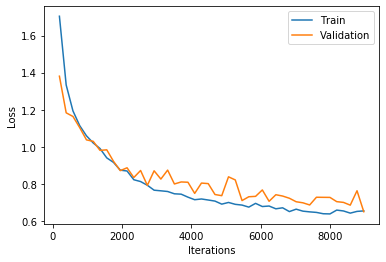

In [5]:
import torch
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, global_max_pool
from torch_scatter import scatter_mean, scatter_max 
import matplotlib.pyplot as plt
from torch_geometric.utils import dropout_adj

#Use wandb to optimise and log performance of system. 
# weights and biases

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(3, 16, cached=False)
        self.conv2 = GCNConv(16, 32, cached=False)
        self.conv3 = GCNConv(32, 64, cached=False)
        self.conv4 = GCNConv(64, 64, cached=False)
        self.linear1 = torch.nn.Linear(64, 10)

    def forward(self, data):
        x, edge_index, batch = data.pos, data.edge_index, data.batch    
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)
        x = self.linear1(x)
        x = scatter_mean(x, batch, dim=0)  
        
        return F.log_softmax(x, dim=1)
    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train_losses = []
val_losses = []
val_lower = 0.65

count = -1
for epoch in range(200):
    running_loss = 0.0
    val_running_loss = 0.0
    model.train()
    for i, batch in enumerate(train_loader, 0):
        count += 1
        data = batch.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    mean_loss = running_loss/(i+1)
    train_losses.append((count, mean_loss))
    print('Epoch:', epoch)
    print('Train loss:', mean_loss)
        
    model.eval()
    with torch.no_grad():
        for j, batch_val in enumerate(val_loader, 0):
            data_val = batch_val.to(device)
            out_val = model(data_val)
            val_loss = F.nll_loss(out_val, data_val.y)
            val_running_loss += val_loss.item()
        val_mean_loss = val_running_loss/(j+1)
        val_losses.append((count, val_mean_loss))
        print('Validation loss:', val_mean_loss)
        
    if val_mean_loss <= val_lower:
        break
              
print('Finished Training')

list1, list2 = zip(*train_losses)
list3, list4 = zip(*val_losses)

plt.plot(list1, list2, list3, list4)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend(('Train', 'Validation'))

running the cell below will test the performance of the network

In [11]:
import torch
from CreateDataset import Dataset
import numpy as np
from torch_geometric.data import Data, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


data_path = 'tmp/raw'
dataset_test = Dataset(path=data_path, train=False)
dataset_test = dataset_test.create_dataset()
dataset_test, idx = dataset_test
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True)


classes = ('bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night-stand', 'sofa', 'table', 'toilet')
correct = 0
correct_categories = []
predictions = []
labels = []

total = 0
class_total = list(0. for i in range(len(classes)))
class_correct = list(0. for i in range(len(classes)))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        outputs = model(data)
        outputs = torch.exp(outputs.data)
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted.tolist())
        labels.append(data.y.tolist())
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()
        correct_categories.append(predicted[predicted == data.y].tolist())
        c = (predicted == data.y).squeeze().cpu()
        
        for i in range(len(c)):
            label = data.y[i]
            class_correct[label] += c[i].numpy()
            class_total[label] += 1

    for i in range(len(classes)):
        print('Accuracy of {:5s} : {:5.2f} %'.format(
                classes[i], 100 * class_correct[i] / class_total[i]))


print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


labels_flat = [item for sublist in labels for item in sublist]
predictions_flat = [item for sublist in predictions for item in sublist]

class_predictions_all = []

for i in range(10):
    labels_idx = [index for index, value in enumerate(labels_flat) if value == i]
    class_predictions = np.asarray(predictions_flat)[np.asarray(labels_idx)]
    class_predictions_all.append(class_predictions)


Accuracy of bathtub : 68.00 %
Accuracy of bed   : 86.00 %
Accuracy of chair : 91.00 %
Accuracy of desk  : 45.35 %
Accuracy of dresser : 70.93 %
Accuracy of monitor : 84.00 %
Accuracy of night-stand : 55.81 %
Accuracy of sofa  : 90.00 %
Accuracy of table : 63.00 %
Accuracy of toilet : 84.00 %
Accuracy of the network on the test images: 74 %


this concludes the main results of the dl model 